In [1]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Repeat Rutter & Dekker et al 2024 analysis

In [2]:
# Import the data
PM3_EntA_data = get_data('PM3-EntA-coculture.csv')

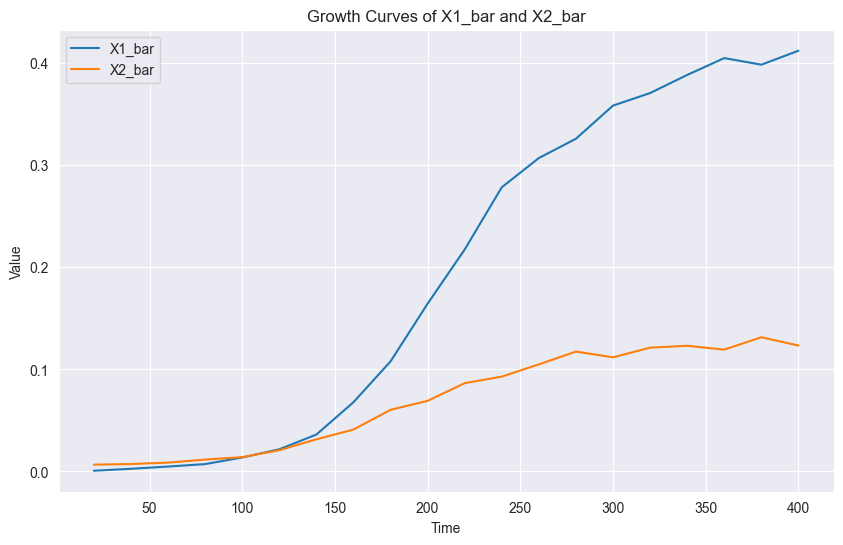

In [3]:
# Visualise the mean of the growth curves of both species grown in co-culture together
plot_growth_curves(PM3_EntA_data)

In [4]:
# Extract data and convert to numpyarrays

yobsdf = PM3_EntA_data.iloc[:, [1,2]]
yobs = yobsdf.to_numpy()
timesa = PM3_EntA_data.iloc[:, 0]
times = timesa.to_numpy()

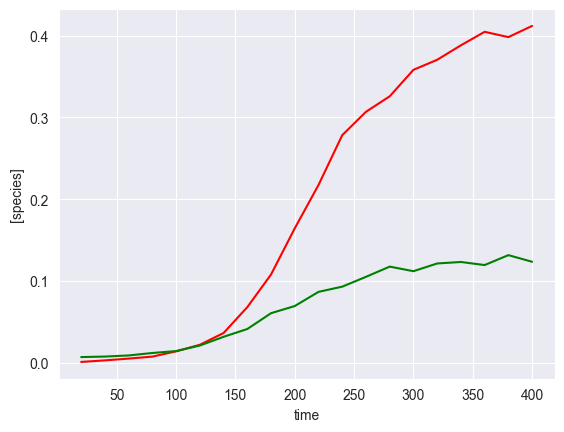

In [5]:
plot_gLV(yobs, times)

In [6]:
X, F = linearize_time_course_16S(yobs, times)
print(X.shape)
print(F)

(19, 3)
[[ 0.06410781  0.00451447]
 [ 0.030741    0.00864193]
 [ 0.02029504  0.01491441]
 [ 0.03195409  0.00920276]
 [ 0.02306859  0.01972501]
 [ 0.02551347  0.02072131]
 [ 0.031458    0.01324291]
 [ 0.02318223  0.01933004]
 [ 0.02108645  0.00678014]
 [ 0.01398885  0.01118549]
 [ 0.01235913  0.00355461]
 [ 0.00489876  0.00609444]
 [ 0.00298835  0.00563386]
 [ 0.00474679 -0.00245348]
 [ 0.00168398  0.00406172]
 [ 0.00233942  0.00074916]
 [ 0.00208133 -0.00155351]
 [-0.000806    0.0048483 ]
 [ 0.00168939 -0.00319625]]


X shape: (19, 3)
F shape: (19, 2)
Number of species: 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


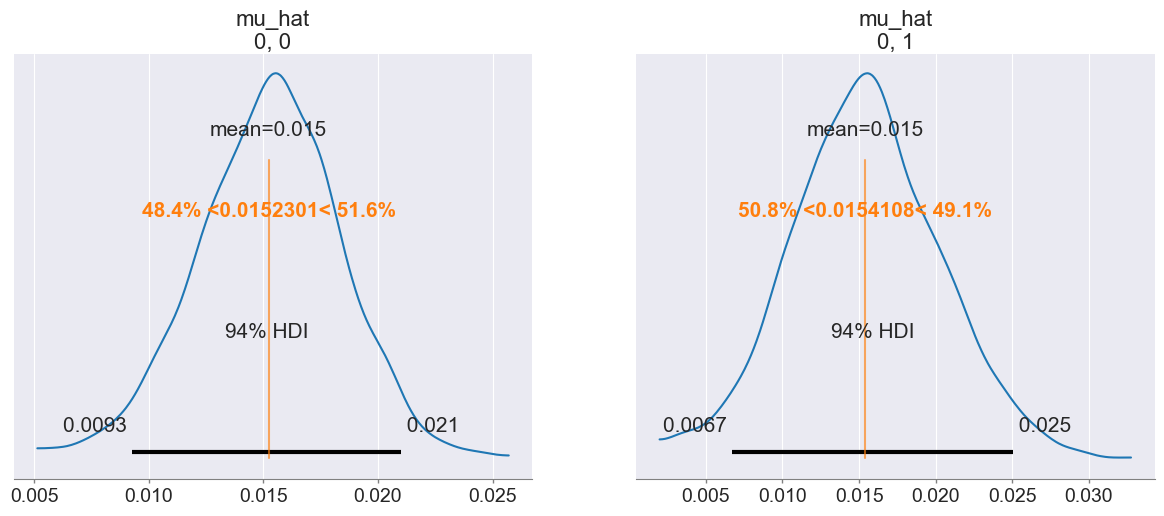

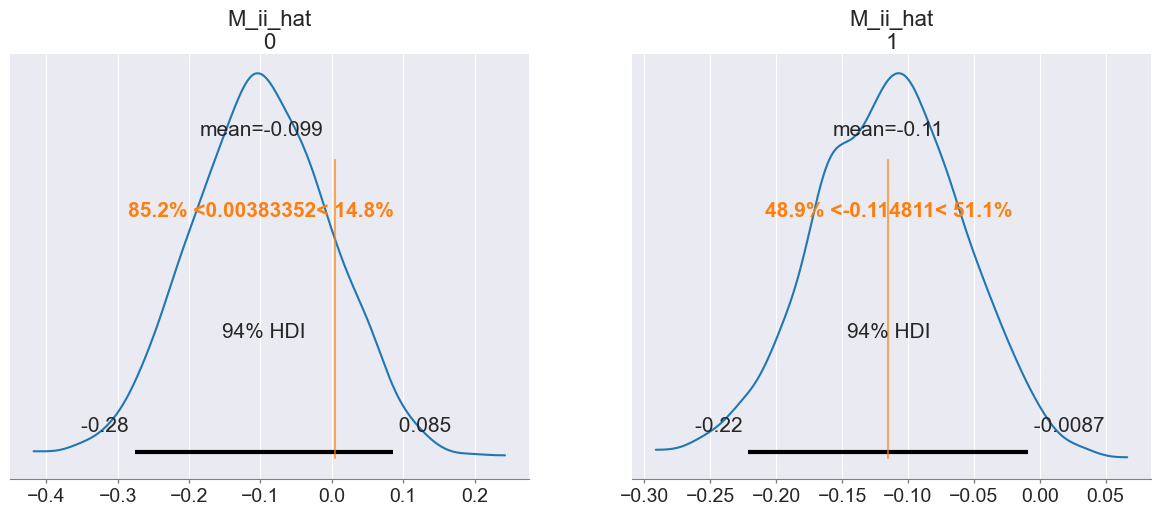

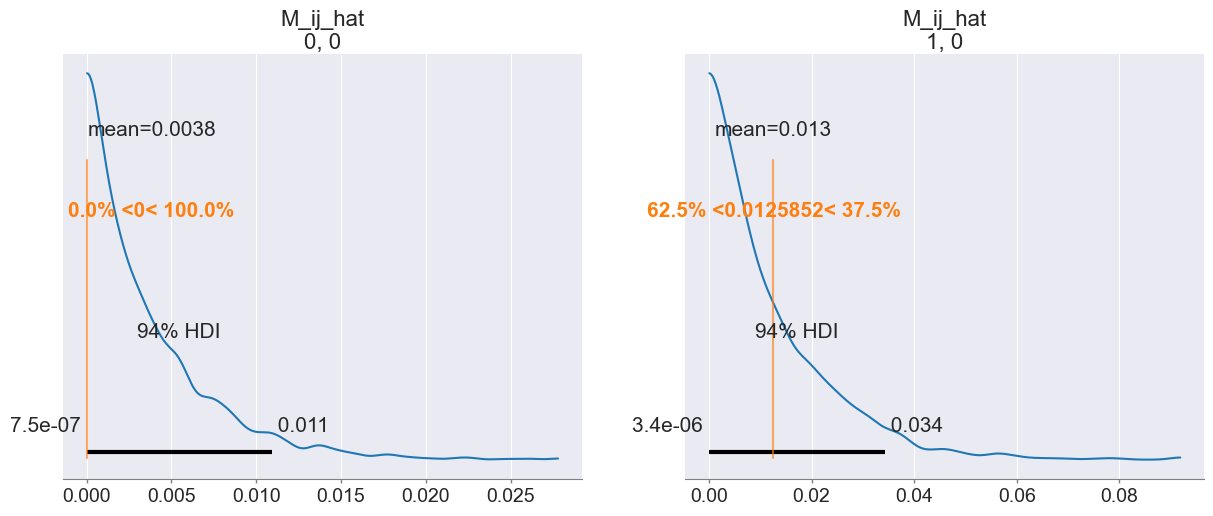

In [7]:
# Perform Bayesian inference without shrinkage

# Define priors
prior_mu_mean = 0.03
prior_mu_sigma = 0.5

## NB prior_Mii_mean is 0 and incorporated as halfnormal, so not defined as an argument
prior_Mii_sigma = 0.1
prior_Mii_mean =  0.1

prior_Mij_sigma = 0.1


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = infergLVbayes(X, F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_bayes_gLV()

In [8]:
#inference.plot_posterior(idata, mu_hat_np, M_hat_np)

In [9]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

                 mean     sd  r_hat
mu_hat[0, 0]    0.015  0.003   1.00
mu_hat[0, 1]    0.015  0.005   1.01
M_ii_hat[0]    -0.099  0.099   1.00
M_ii_hat[1]    -0.115  0.056   1.01
M_ij_hat[0, 0]  0.004  0.004   1.00
M_ij_hat[1, 0]  0.013  0.012   1.00
M_hat[0, 0]     0.004  0.004   1.00
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]     0.013  0.012   1.00
M_hat[1, 1]    -0.115  0.056   1.01
sigma[0]        0.013  0.002   1.00


/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


'model_posterior.nc'

(4, 500, 2, 2)
(4, 500, 1, 2)
Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.0153743 , 0.01530408]), 'M': array([[ 0.0026559 ,  0.        ],
       [ 0.00874137, -0.11332713]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


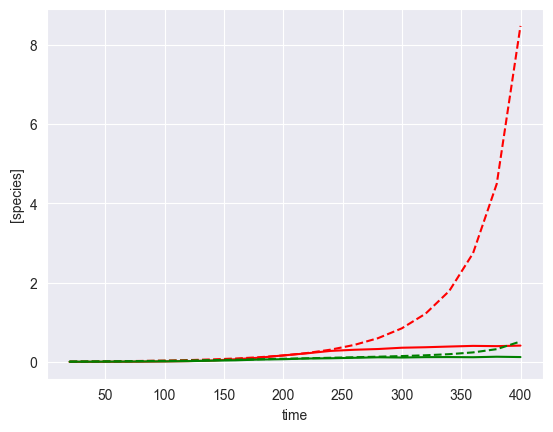

In [11]:
init_species_start = 0.01
sim_gLV_class = sim_gLV()
curve_compare(idata, F, prior_mu_mean, prior_Mii_mean, times, yobs, init_species_start, sim_gLV_class)

## Perform Bayesian inference with shrinkage

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━  92% 0:00:01 / 0:00:03

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


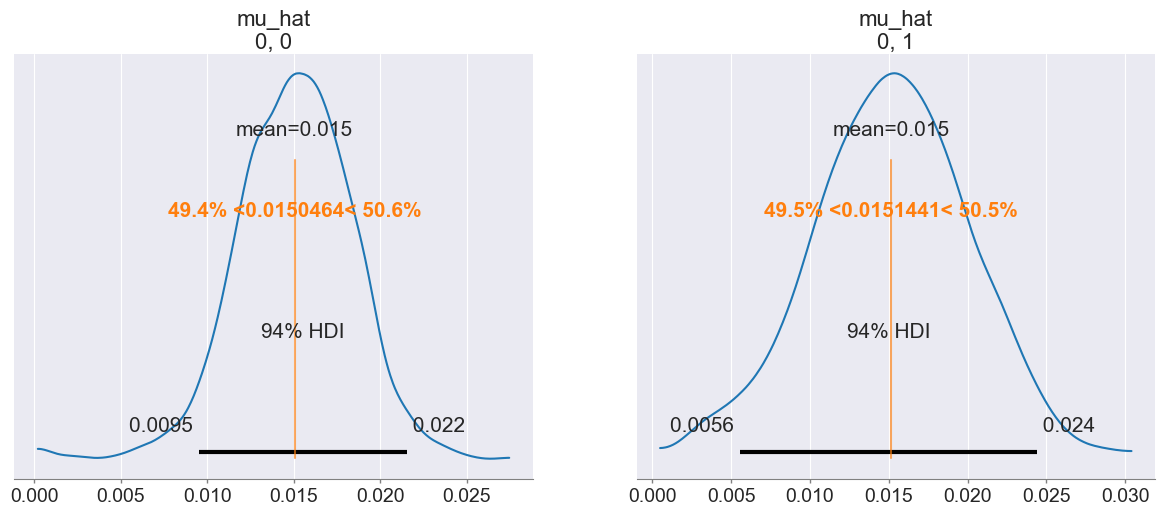

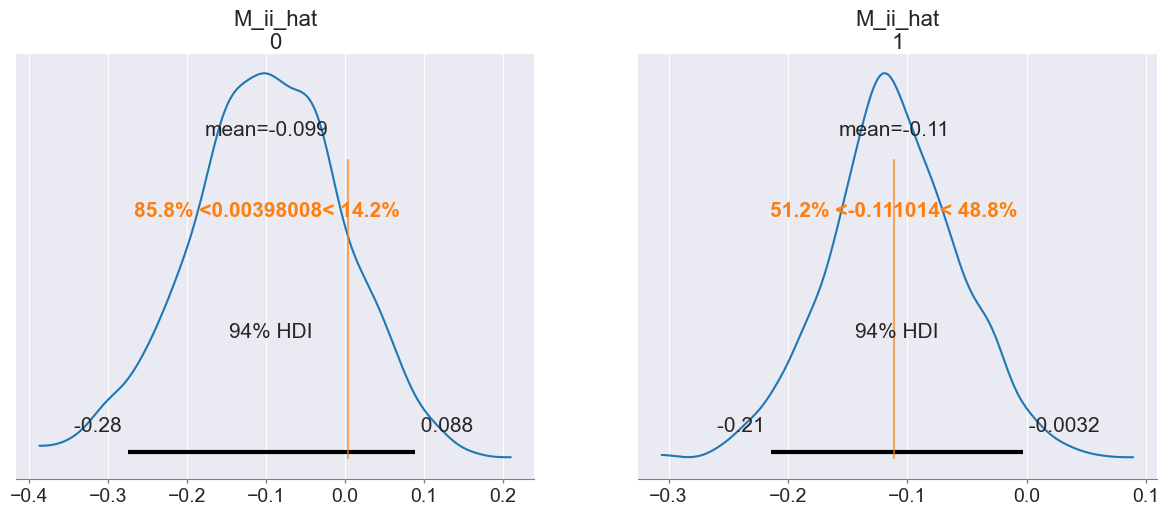

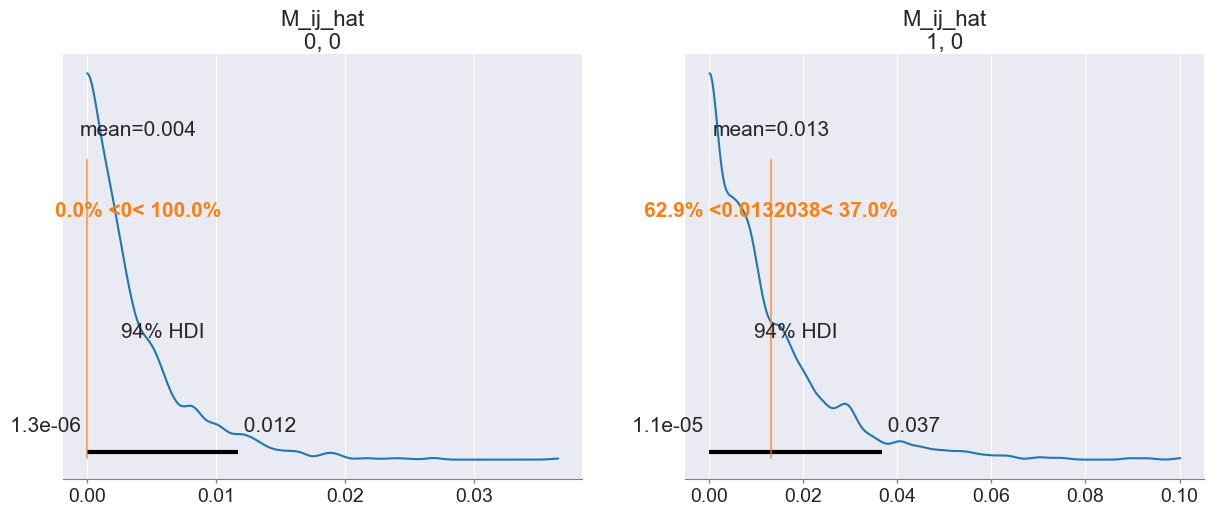

In [7]:
# Define priors
prior_mu_mean = 0.03
prior_mu_sigma = 0.5

prior_Mii_mean =  0.1
prior_Mii_sigma = 0.1

## NB prior_Mij_mean is 0 and incorporated as halfnormal, so not defined as an argument
prior_Mij_sigma = 0.1

# Define parameters for shrinkage on M_ij (non diagonal elements)
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1

DA = nX*nX - nX

DA0 = 1     # expected number of non zero entries in M_ij
N = n_obs - 2


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

# Run inference
inference = infergLVbayes(X, F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_bayes_gLV_shrinkage()

In [8]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

                 mean     sd  r_hat
mu_hat[0, 0]    0.015  0.003   1.01
mu_hat[0, 1]    0.015  0.005   1.00
M_ii_hat[0]    -0.099  0.096   1.00
M_ii_hat[1]    -0.111  0.056   1.00
M_ij_hat[0, 0]  0.004  0.004   1.00
M_ij_hat[1, 0]  0.013  0.013   1.00
M_hat[0, 0]     0.004  0.004   1.00
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]     0.013  0.013   1.00
M_hat[1, 1]    -0.111  0.056   1.00
sigma[0]        0.013  0.002   1.01


/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


'model_posterior.nc'

In [9]:
curve_compare(idata, F, prior_mu_mean, prior_Mii_mean, times, yobs, init_species_start, sim_gLV_class)

NameError: name 'init_species_start' is not defined